# Import libraries

In [1]:
import os
import getpass
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import csv
import umap
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from itertools import product
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import euclidean_distances
import random
import re

2024-04-28 11:18:13.620266: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-28 11:18:13.648771: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-28 11:18:13.648795: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-28 11:18:13.649517: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-28 11:18:13.654299: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-28 11:18:13.655285: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
def extract_email(arr):
    # Check if the input is a list or array
    if isinstance(arr, list) or isinstance(arr, np.ndarray):
        # Iterate through each element
        for element in arr:
            # Recursively call the function for nested lists or arrays
            email = extract_email(element)
            if email is not None:
                return email
    # If it's a string, check if it's an email address
    elif isinstance(arr, str):
        if re.match(r"[^@]+@[^@]+\.[^@]+", arr):
            return arr
    # Return None if no email address is found
    return None

In [3]:
question_significance = {
    "seating_question_1": "Salt or Paprika?",
    "seating_question_2": "Which starter pokemon would you choose?",
    "seating_question_3": "Which Hogward house are you?",
    "seating_question_4": "Ideal friday evening?",
    "seating_question_5": "What's your favorite drink?",
    "seating_question_6": "What is most likely to exist?",
    "seating_question_7": "What is the best aroma?",
    "seating_question_8": "What where we talking about?",
    "seating_question_9": "What is your favoured language?",
    "seating_question_10": "Who do you prefer?",
}

weigths = {
    "seating_question_1": 0.5,
    "seating_question_2": 1,
    "seating_question_3": 2,
    "seating_question_4": 2,
    "seating_question_5": 6,
    "seating_question_6": 6,
    "seating_question_7": 4,
    "seating_question_8": 3,
    "seating_question_9": 5,
    "seating_question_10": 1,
}

In [4]:
# Function to update values
def update_values(value_counts):
    def update(x):
        count = value_counts.get(x)
        if count:
            return f"{x}-{count}"
        else:
            return x
    return update

In [5]:

server = "ec2-54-72-196-9.eu-west-1.compute.amazonaws.com"
db = "d2fect8juldk3k"
user = "puybkltrealynp"
pswd = getpass.getpass(prompt="Enter password: ")
pswd_to_enter = "10aefdea5dcd6a4366ab1e0f46cbf91366144b7a3ad7252478db2c63357fec4e"
# Set the PGPASSWORD environment variable
os.environ['PGPASSWORD'] = pswd

# Execute the PostgreSQL command without specifying the password
os.system(f"psql -h {server} -U {user} -d {db} -c 'SELECT name, email, name, family_name, has_answered_form, answer_friday, answer_diner, answer_ceremony, answer_reception, plusones, seating_question_1, seating_question_2, seating_question_3, seating_question_4, seating_question_5, seating_question_6, seating_question_7, seating_question_8, seating_question_9, seating_question_10, seating_question_11, seating_question_12, seating_question_13, seating_question_14, seating_question_15 FROM users;' -o seatings.csv")


Enter password:  ········


0

# Load complete database

In [6]:
full_csv = pd.read_csv(f"seatings.csv", delimiter="|")
# Strip leading and trailing spaces from every element in the DataFrame
full_csv = full_csv.applymap(lambda x: x.strip() if isinstance(x, str) else x)
full_csv.columns = full_csv.columns.str.strip()
full_csv = full_csv.dropna()

/tmp/ipykernel_32880/2183413473.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  full_csv = full_csv.applymap(lambda x: x.strip() if isinstance(x, str) else x)


In [7]:
full_csv['email'] = full_csv['email'].str.lower()
full_csv['email'] = full_csv['email'].str.rstrip('.')
full_csv.to_csv(f"seating_cleaned.csv")
full_csv

,name,email,name .1,family_name,has_answered_form,answer_friday,answer_diner,answer_ceremony,answer_reception,plusones,...,seating_question_6,seating_question_7,seating_question_8,seating_question_9,seating_question_10,seating_question_11,seating_question_12,seating_question_13,seating_question_14,seating_question_15
1,Pierre,pietdel@gmail.com,Pierre,Delacroix,yes,no,yes,no,yes,,...,06_aliens,07_pepper,08_spices,09_france,10_love_math,,,,,
2,Alexis,alexis@adbproduction.com,Alexis,,yes,no,no,no,no,,...,06_nessie,07_chocolate,08_sex,09_france,10_love_math,,,,,
3,Margotta,mgx.vansteenbergh@hotmail.com,Margotta,,no,no,no,no,no,,...,,,,,,,,,,
4,Caroline,carolinewvh@gmail.com,Caroline,Wesselman van Helmond,yes,no,yes,no,yes,leonore.vehmeijer@gmail.com,...,06_ghost,07_chocolate,08_icecream,09_unitedkingdom,10_love_math,,,,,
5,Erica,erica.efst@gmail.com,Erica,Efstratoudakis,yes,yes,yes,yes,yes,aamoratis@gmail.com,...,06_aliens,07_chocolate,08_icecream,09_unitedkingdom,10_love_liv,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208,Dara,khosrowshahidara@gmail.com,Dara,Khosrowshahi,yes,no,yes,no,yes,,...,06_ghost,07_pepper,08_sex,09_france,10_love_math,,,,,
209,BigNickkk,bignick@blasband.com,BigNickkk,Blasband,yes,no,yes,no,no,,...,,,,,,,,,,
210,Nikou,nikou.kh03@gmail.com,Nikou,,yes,no,yes,no,yes,,...,06_aliens,07_pistachio,08_icecream,09_france,10_love_math,,,,,
211,Alicia,alice.athanassiadis@gmail.com,Alicia,,yes,no,yes,no,yes,alexis.philippartdefoy@gmail.com,...,06_aliens,07_chocolate,08_icecream,09_france,10_love_math,,,,,


# People who answered but answered no (to double check)

In [8]:
check = full_csv[full_csv["has_answered_form"] == "yes"]
check = check[check["answer_diner"] == "no"]
check

,name,email,name .1,family_name,has_answered_form,answer_friday,answer_diner,answer_ceremony,answer_reception,plusones,...,seating_question_6,seating_question_7,seating_question_8,seating_question_9,seating_question_10,seating_question_11,seating_question_12,seating_question_13,seating_question_14,seating_question_15
2,Alexis,alexis@adbproduction.com,Alexis,,yes,no,no,no,no,,...,06_nessie,07_chocolate,08_sex,09_france,10_love_math,,,,,
20,Laureline,laureline.maheo@yahoo.fr,Laureline,,yes,no,no,no,no,,...,,,,,,,,,,
22,Clarinette,cldursel@gmail.com,Clarinette,d'Ursel,yes,no,no,no,no,,...,,,,,,,,,,
32,Amelie,ami@dg.com,Amelie,,yes,no,no,no,no,Livia,...,06_god,07_pepper,08_spices,09_unitedkingdom,10_love_math,,,,,
33,Kyril,kyrilwittouck@gmail.com,Kyril,,yes,no,no,no,no,,...,,,,,,,,,,
35,Valentine,vdeselliers@hotmail.com,Valentine,,yes,no,no,no,no,kyrilwittouck@gmail.com,...,,,,,,,,,,
37,Pauline,paulinefaucon@hotmail.com,Pauline,,yes,no,no,no,no,,...,,,,,,,,,,
44,Isaure,isauredv@gmail.com,Isaure,,yes,no,no,no,no,,...,,,,,,,,,,
49,Olivier,odeguerre@free.fr,Olivier,,yes,no,no,no,no,,...,06_nessie,07_chocolate,08_icecream,09_france,10_love_liv,,,,,
52,Sarah,sarah.cresap.johnson@gmail.com,Sarah,Clemm,yes,no,no,no,no,,...,06_nessie,07_pistachio,08_icecream,09_unitedkingdom,10_love_liv,,,,,


# Double check the plusones to include them

In [9]:
where_plus_ones = full_csv[full_csv["plusones"].str.strip() != ""][['name','email','plusones']]
where_plus_ones['plusones'] = where_plus_ones['plusones'].str.rstrip('.')
temp = pd.DataFrame()
temp['email'] = list(where_plus_ones['plusones'])
temp['who_invites_them'] = list(where_plus_ones['email'])
# Assuming df1 and df2 are your DataFrames
merged_df = pd.merge(temp, full_csv[['email','name']],on='email', how='left')
merged_df
# Filter out rows with NaN values in the columns from df2
excluded_rows = merged_df[merged_df['name'].isnull()]
excluded_rows

,email,who_invites_them,name
9,Livia,ami@dg.com,NaN
22,Eugenia Caravaca Bayo,sebdeschrevel@hotmail.com,NaN
23,Louise Snoy,laurent.michiels@bain.com,NaN
28,Ania,philippe.labouchere@gmail.com,NaN
29,eleanor,zoomacc89@hotmail.com,NaN
37,Thomas,valeriedeguerre@gmail.com,NaN
38,Alexandre Quarles van Ufford,odeborchgrave@gmail.com,NaN
39,Laurence de Guerre,dominique.de.guerre@orange.fr,NaN
41,Isabelle,amarschall@ab-marschall.de,NaN
42,Alexander Wynaendts,cwynaendts@gmail.com,NaN


# Load additional information

In [10]:
additional = pd.read_csv(f"important_info.csv", delimiter=",",header=0)
additional['email'] = additional['email'].str.lower()
additional['email'] = additional['email'].str.rstrip('.')
additional

,email,Sex,friend_of,table,single
0,victor.stinglhamber@gmail.com,male,10_mat,1,single
1,bertichat@gmail.com,male,10_mat,1,not single
2,fdelimburg@gmail.com,male,10_mat,1,single
3,jdursel@gmail.com,male,10_mat,1,not single
4,harold.loop@gmail.com,male,10_mat,1,not single
...,...,...,...,...,...
202,kyrilwittouck@gmail.com,male,10_mat,0,not single
203,laureline.maheo@yahoo.fr,female,10_mat,0,not single
204,paulinefaucon@hotmail.com,female,10_mat,0,single
205,vdeselliers@hotmail.com,female,10_mat,0,not single


In [11]:
merged_total = pd.merge(full_csv, additional[['email','Sex', 'friend_of','table','single']], on='email', how='inner')

duplicated_indices = [6]
while len(duplicated_indices) > 0:
    try:
        duplicated_indices = merged_total[merged_total.duplicated(subset=['email'], keep=False)].index
        index_to_drop = np.random.choice(duplicated_indices)
        merged_total = merged_total.drop(index_to_drop)
    except Exception as e:
        print(e)

'a' cannot be empty unless no samples are taken


# Filter out parents

In [12]:
youth = merged_total[merged_total["friend_of"]!="10_parents"]
youth

,name,email,name .1,family_name,has_answered_form,answer_friday,answer_diner,answer_ceremony,answer_reception,plusones,...,seating_question_10,seating_question_11,seating_question_12,seating_question_13,seating_question_14,seating_question_15,Sex,friend_of,table,single
0,Pierre,pietdel@gmail.com,Pierre,Delacroix,yes,no,yes,no,yes,,...,10_love_math,,,,,,male,10_mat,1,not single
1,Caroline,carolinewvh@gmail.com,Caroline,Wesselman van Helmond,yes,no,yes,no,yes,leonore.vehmeijer@gmail.com,...,10_love_math,,,,,,female,10_mat,0,not single
2,Erica,erica.efst@gmail.com,Erica,Efstratoudakis,yes,yes,yes,yes,yes,aamoratis@gmail.com,...,10_love_liv,,,,,,female,10_liv,1,not single
3,Darren,darrenmk1@gmail.com,Darren,Kripaitis,yes,no,yes,yes,yes,,...,10_love_math,,,,,,male,10_mat,0,not single
4,Charles-Henri,ch.starckmann@gmail.com,Charles-Henri,Starckmann,yes,no,yes,no,yes,,...,10_love_liv,,,,,,male,10_mat,1,not single
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197,Reny <3,lukitoreny@hotmail.com,Reny <3,,no,no,no,no,no,,...,,,,,,,female,10_mat,3,not single
198,Dara,khosrowshahidara@gmail.com,Dara,Khosrowshahi,yes,no,yes,no,yes,,...,10_love_math,,,,,,male,10_mat,2,not single
199,BigNickkk,bignick@blasband.com,BigNickkk,Blasband,yes,no,yes,no,no,,...,,,,,,,male,10_mat,3,not single
200,Nikou,nikou.kh03@gmail.com,Nikou,,yes,no,yes,no,yes,,...,10_love_math,,,,,,female,10_mat,2,single


In [13]:
youth[['name','family_name','email','has_answered_form','answer_friday','answer_ceremony','answer_reception','answer_diner']].to_csv(f"./final_youth_db.csv")

In [14]:
parents = merged_total[merged_total["friend_of"]=="10_parents"]
parents[['name','family_name','email','has_answered_form','answer_friday','answer_ceremony','answer_reception','answer_diner']].to_csv(f"./final_parents_db.csv")

# People from who we dont have information

In [15]:
merged_df = pd.merge(full_csv[['email','name']], additional[['email']], on='email', how='outer', suffixes=('_df1', '_df2'))
# Convert lists to sets
set1 = set(list(full_csv['email']))
set2 = set(list(additional['email']))

# Find elements not shared by both sets
elements_not_shared = set1.symmetric_difference(set2)
elements_not_shared

{'alexander.jordaan@gmail.com',
 'alexis@adbproduction.com',
 'bernardo.p.maciel@gmail.com',
 'cato.romero96@gmail.com',
 'chatelainpaul@hotmail.com',
 'i.libedinsky@vu.nl',
 'javi.stauffenberg@gmail.com',
 'jhroselaers@gmail.com',
 'josefinwerme@gmail.com',
 'karenlaupman@gmail.com',
 'mgx.vansteenbergh@hotmail.com',
 'nathan.y.bell@gmail.com',
 'plusone_phillipe',
 'sltettelaar@hotmail.com',
 'zoomacc89@hotmail.com'}

In [16]:
emails_list = list(elements_not_shared)
# Specify the CSV file path
csv_file_path = "not_shared.csv"

# Write list to CSV file
with open(csv_file_path, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['email'])  # Write header
    writer.writerows([[email] for email in emails_list])

# People who answered the form but didnt do the table seating game

In [17]:
answered_invitation_but_didnt_play = youth[youth['has_answered_form'] == 'yes']
answered_invitation_but_didnt_play = answered_invitation_but_didnt_play[answered_invitation_but_didnt_play["seating_question_1"].str.strip() == ""]
answered_invitation_but_didnt_play

,name,email,name .1,family_name,has_answered_form,answer_friday,answer_diner,answer_ceremony,answer_reception,plusones,...,seating_question_10,seating_question_11,seating_question_12,seating_question_13,seating_question_14,seating_question_15,Sex,friend_of,table,single
16,Laureline,laureline.maheo@yahoo.fr,Laureline,,yes,no,no,no,no,,...,,,,,,,female,10_mat,0,not single
18,Clarinette,cldursel@gmail.com,Clarinette,d'Ursel,yes,no,no,no,no,,...,,,,,,,female,10_mat,0,single
29,Kyril,kyrilwittouck@gmail.com,Kyril,,yes,no,no,no,no,,...,,,,,,,male,10_mat,0,not single
31,Valentine,vdeselliers@hotmail.com,Valentine,,yes,no,no,no,no,kyrilwittouck@gmail.com,...,,,,,,,female,10_mat,0,not single
33,Pauline,paulinefaucon@hotmail.com,Pauline,,yes,no,no,no,no,,...,,,,,,,female,10_mat,0,single
40,Isaure,isauredv@gmail.com,Isaure,,yes,no,no,no,no,,...,,,,,,,female,10_mat,0,not single
83,Laurent,laurent.michiels@bain.com,Laurent,Michiels,yes,no,no,no,no,Louise Snoy,...,,,,,,,male,10_mat,0,not single
96,Robert,vdlindenrj@gmail.com,Robert,van der Linden,yes,no,yes,yes,yes,,...,,,,,,,male,10_liv,0,not single
102,Phil,philippe.labouchere@gmail.com,Phil,,yes,no,no,no,no,Ania,...,,,,,,,male,10_liv,1,not single
142,Joyce,joycevn1@gmail.com,Joyce,Van Nieuwerburgh,yes,no,no,no,no,,...,,,,,,,female,10_mat,0,not single


# Randomize the answers of people who didnt do the game

In [18]:
temp = youth[youth["seating_question_1"].str.strip() != ""]

all_questions = ["seating_question_1","seating_question_2","seating_question_3","seating_question_4","seating_question_5","seating_question_6","seating_question_7","seating_question_8","seating_question_9","seating_question_10"]
randomized_answers = []

for quest in all_questions:
    answers = []
    for i in range(len(answered_invitation_but_didnt_play)):
        random_element = random.choice(list(temp[quest]))
        answers.append(random_element)
    answered_invitation_but_didnt_play[quest] = answers

In [19]:
youth = pd.concat([temp, answered_invitation_but_didnt_play], axis=0)
youth

,name,email,name .1,family_name,has_answered_form,answer_friday,answer_diner,answer_ceremony,answer_reception,plusones,...,seating_question_10,seating_question_11,seating_question_12,seating_question_13,seating_question_14,seating_question_15,Sex,friend_of,table,single
0,Pierre,pietdel@gmail.com,Pierre,Delacroix,yes,no,yes,no,yes,,...,10_love_math,,,,,,male,10_mat,1,not single
1,Caroline,carolinewvh@gmail.com,Caroline,Wesselman van Helmond,yes,no,yes,no,yes,leonore.vehmeijer@gmail.com,...,10_love_math,,,,,,female,10_mat,0,not single
2,Erica,erica.efst@gmail.com,Erica,Efstratoudakis,yes,yes,yes,yes,yes,aamoratis@gmail.com,...,10_love_liv,,,,,,female,10_liv,1,not single
3,Darren,darrenmk1@gmail.com,Darren,Kripaitis,yes,no,yes,yes,yes,,...,10_love_math,,,,,,male,10_mat,0,not single
4,Charles-Henri,ch.starckmann@gmail.com,Charles-Henri,Starckmann,yes,no,yes,no,yes,,...,10_love_liv,,,,,,male,10_mat,1,not single
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142,Joyce,joycevn1@gmail.com,Joyce,Van Nieuwerburgh,yes,no,no,no,no,,...,10_love_liv,,,,,,female,10_mat,0,not single
147,Guix,guillaume.doultremont@gmail.com,Guix,d'Oultremont,yes,no,no,no,no,,...,10_love_math,,,,,,male,10_mat,0,single
160,Zarah & Duco,duco@duna.io,Zarah & Duco,van Lanschot - Abeln,yes,no,yes,yes,yes,,...,10_love_liv,,,,,,male,10_liv,0,not single
200,BigNickkk,bignick@blasband.com,BigNickkk,Blasband,yes,no,yes,no,no,,...,10_love_liv,,,,,,male,10_mat,3,not single


# All people who at least started the table seating game

In [20]:
only_answered = youth[youth["seating_question_1"].str.strip() != ""]
only_answered

,name,email,name .1,family_name,has_answered_form,answer_friday,answer_diner,answer_ceremony,answer_reception,plusones,...,seating_question_10,seating_question_11,seating_question_12,seating_question_13,seating_question_14,seating_question_15,Sex,friend_of,table,single
0,Pierre,pietdel@gmail.com,Pierre,Delacroix,yes,no,yes,no,yes,,...,10_love_math,,,,,,male,10_mat,1,not single
1,Caroline,carolinewvh@gmail.com,Caroline,Wesselman van Helmond,yes,no,yes,no,yes,leonore.vehmeijer@gmail.com,...,10_love_math,,,,,,female,10_mat,0,not single
2,Erica,erica.efst@gmail.com,Erica,Efstratoudakis,yes,yes,yes,yes,yes,aamoratis@gmail.com,...,10_love_liv,,,,,,female,10_liv,1,not single
3,Darren,darrenmk1@gmail.com,Darren,Kripaitis,yes,no,yes,yes,yes,,...,10_love_math,,,,,,male,10_mat,0,not single
4,Charles-Henri,ch.starckmann@gmail.com,Charles-Henri,Starckmann,yes,no,yes,no,yes,,...,10_love_liv,,,,,,male,10_mat,1,not single
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142,Joyce,joycevn1@gmail.com,Joyce,Van Nieuwerburgh,yes,no,no,no,no,,...,10_love_liv,,,,,,female,10_mat,0,not single
147,Guix,guillaume.doultremont@gmail.com,Guix,d'Oultremont,yes,no,no,no,no,,...,10_love_math,,,,,,male,10_mat,0,single
160,Zarah & Duco,duco@duna.io,Zarah & Duco,van Lanschot - Abeln,yes,no,yes,yes,yes,,...,10_love_liv,,,,,,male,10_liv,0,not single
200,BigNickkk,bignick@blasband.com,BigNickkk,Blasband,yes,no,yes,no,no,,...,10_love_liv,,,,,,male,10_mat,3,not single


# Weird group who played but answered no for dinner

In [21]:
weird_group = only_answered[only_answered["answer_diner"] == "no"]
weird_group

,name,email,name .1,family_name,has_answered_form,answer_friday,answer_diner,answer_ceremony,answer_reception,plusones,...,seating_question_10,seating_question_11,seating_question_12,seating_question_13,seating_question_14,seating_question_15,Sex,friend_of,table,single
31,Amelie,ami@dg.com,Amelie,,yes,no,no,no,no,Livia,...,10_love_math,,,,,,female,10_mat,0,single
48,Sarah,sarah.cresap.johnson@gmail.com,Sarah,Clemm,yes,no,no,no,no,,...,10_love_liv,,,,,,female,10_liv,0,not single
67,Tony,adenicolay@gmail.com,Tony,de Nicolay,yes,no,no,no,no,,...,10_love_math,,,,,,male,10_mat,0,single
87,Aad,adriaanvanberckel2009@hotmail.com,Aad,,yes,no,no,no,no,,...,,,,,,,male,10_liv,0,single
158,Gaspar,gdursel@gmail.com,Gaspar,d'Ursel,yes,no,no,no,no,,...,10_love_liv,,,,,,male,10_mat,0,single
16,Laureline,laureline.maheo@yahoo.fr,Laureline,,yes,no,no,no,no,,...,10_love_liv,,,,,,female,10_mat,0,not single
18,Clarinette,cldursel@gmail.com,Clarinette,d'Ursel,yes,no,no,no,no,,...,10_love_math,,,,,,female,10_mat,0,single
28,Kyril,kyrilwittouck@gmail.com,Kyril,,yes,no,no,no,no,,...,10_love_liv,,,,,,male,10_mat,0,not single
30,Valentine,vdeselliers@hotmail.com,Valentine,,yes,no,no,no,no,kyrilwittouck@gmail.com,...,10_love_math,,,,,,female,10_mat,0,not single
33,Pauline,paulinefaucon@hotmail.com,Pauline,,yes,no,no,no,no,,...,10_love_liv,,,,,,female,10_mat,0,single


In [22]:
len(only_answered)

161

# Filtering out those who said no to the diner

In [23]:
only_answered = only_answered[only_answered["answer_diner"]!="no"]

# Double checking one last time plusones

In [24]:
where_plus_ones = only_answered[only_answered["plusones"].str.strip() != ""][['name','email','plusones']]
where_plus_ones['plusones'] = where_plus_ones['plusones'].str.rstrip('.')
temp = pd.DataFrame()
temp['email'] = list(where_plus_ones['plusones'])
temp['who_invites_them'] = list(where_plus_ones['email'])
# Assuming df1 and df2 are your DataFrames
merged_df = pd.merge(temp, only_answered[['email','name']],on='email', how='left')
merged_df
# Filter out rows with NaN values in the columns from df2
excluded_rows = merged_df[merged_df['name'].isnull()]
excluded_rows

,email,who_invites_them,name
2,philipvb@outlook.com,mpwesterwoudt@gmail.com,NaN
19,laureline.maheo@yahoo.fr,charko.doultremont@gmail.com,NaN
20,Eugenia Caravaca Bayo,sebdeschrevel@hotmail.com,NaN


# Only seating questions to encode

In [25]:
only_seating_colls = only_answered[["friend_of","table","single","seating_question_1","seating_question_2","seating_question_3","seating_question_4","seating_question_5","seating_question_6","seating_question_7","seating_question_8","seating_question_9","seating_question_10"]]
only_seating_colls = only_seating_colls.applymap(lambda x: str(x).split('_')[-1])
only_seating_colls.replace(r'^\s*$', "no answer", regex=True, inplace=True)
only_seating_colls

/tmp/ipykernel_3134/4081774514.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  only_seating_colls = only_seating_colls.applymap(lambda x: str(x).split('_')[-1])


,friend_of,table,single,seating_question_1,seating_question_2,seating_question_3,seating_question_4,seating_question_5,seating_question_6,seating_question_7,seating_question_8,seating_question_9,seating_question_10
0,mat,1,not single,paprika,charmander,gryffondor,browncafe,wine,aliens,pepper,spices,france,math
1,mat,0,not single,paprika,squirtle,huffelpuf,clubbing,tea,ghost,chocolate,icecream,unitedkingdom,math
2,liv,1,not single,salt,squirtle,gryffondor,browncafe,wine,aliens,chocolate,icecream,unitedkingdom,liv
3,mat,0,not single,salt,bulbasaur,huffelpuf,browncafe,beer,aliens,pistachio,spices,unitedkingdom,math
4,mat,1,not single,paprika,squirtle,gryffondor,browncafe,beer,nessie,chocolate,icecream,france,liv
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,liv,0,not single,paprika,charmander,huffelpuf,clubbing,beer,ghost,chocolate,sex,unitedkingdom,math
101,liv,0,not single,salt,charmander,slitherin,clubbing,beer,reptilian,chocolate,icecream,netherlands,liv
160,liv,0,not single,salt,charmander,gryffondor,browncafe,wine,ghost,pistachio,sex,france,liv
200,mat,3,not single,salt,charmander,gryffondor,browncafe,gin,aliens,pepper,spices,france,liv


In [26]:
mask = (only_seating_colls == "no answer").any(axis=1)
temp = only_answered[['name','email']]
temp = pd.concat([temp, only_seating_colls], axis = 1)
not_finished_answering = temp[mask]
not_finished_answering

,name,email,friend_of,table,single,seating_question_1,seating_question_2,seating_question_3,seating_question_4,seating_question_5,seating_question_6,seating_question_7,seating_question_8,seating_question_9,seating_question_10


In [27]:
filtered_df = only_seating_colls[~mask]
needed_later = only_answered
needed_later = needed_later[~mask]
filtered_df

,friend_of,table,single,seating_question_1,seating_question_2,seating_question_3,seating_question_4,seating_question_5,seating_question_6,seating_question_7,seating_question_8,seating_question_9,seating_question_10
0,mat,1,not single,paprika,charmander,gryffondor,browncafe,wine,aliens,pepper,spices,france,math
1,mat,0,not single,paprika,squirtle,huffelpuf,clubbing,tea,ghost,chocolate,icecream,unitedkingdom,math
2,liv,1,not single,salt,squirtle,gryffondor,browncafe,wine,aliens,chocolate,icecream,unitedkingdom,liv
3,mat,0,not single,salt,bulbasaur,huffelpuf,browncafe,beer,aliens,pistachio,spices,unitedkingdom,math
4,mat,1,not single,paprika,squirtle,gryffondor,browncafe,beer,nessie,chocolate,icecream,france,liv
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,liv,0,not single,paprika,charmander,huffelpuf,clubbing,beer,ghost,chocolate,sex,unitedkingdom,math
101,liv,0,not single,salt,charmander,slitherin,clubbing,beer,reptilian,chocolate,icecream,netherlands,liv
160,liv,0,not single,salt,charmander,gryffondor,browncafe,wine,ghost,pistachio,sex,france,liv
200,mat,3,not single,salt,charmander,gryffondor,browncafe,gin,aliens,pepper,spices,france,liv


In [28]:
# Initialize OneHotEncoder
encoder = OneHotEncoder()
# Fit and transform the data
encoded_data = encoder.fit_transform(filtered_df)

In [29]:
one_hot_encoded = pd.DataFrame(encoded_data.toarray(), columns = encoder.get_feature_names_out())

In [30]:
one_hot_encoded

,friend_of_liv,friend_of_mat,table_0,table_1,table_2,table_3,single_not single,single_single,seating_question_1_paprika,seating_question_1_salt,...,seating_question_7_vanilla,seating_question_8_icecream,seating_question_8_sex,seating_question_8_spices,seating_question_9_france,seating_question_9_germany,seating_question_9_netherlands,seating_question_9_unitedkingdom,seating_question_10_liv,seating_question_10_math
0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
4,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
142,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
143,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
144,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0


# Weight the different questions differently

In [31]:
nr_features = {
    "friend_of": 2,
    "table": 4,
    "single":2,
    "seating_question_1": 2,
    "seating_question_2": 3,
    "seating_question_3": 4,
    "seating_question_4": 3,
    "seating_question_5": 6,
    "seating_question_6": 5,
    "seating_question_7": 4,
    "seating_question_8": 3,
    "seating_question_9": 4,
    "seating_question_10": 2,
}

question_significance = {
    "friend_of": "Who is inviting them?",
    "table": "which table",
    "single": "Relationship status?",
    "seating_question_1": "Salt or Paprika?",
    "seating_question_2": "Which starter pokemon would you choose?",
    "seating_question_3": "Which Hogward house are you?",
    "seating_question_4": "Ideal friday evening?",
    "seating_question_5": "What's your favorite drink?",
    "seating_question_6": "What is most likely to exist?",
    "seating_question_7": "What is the best aroma?",
    "seating_question_8": "What where we talking about?",
    "seating_question_9": "What is your favoured language?",
    "seating_question_10": "Who do you prefer?",
}


weigths = {
    "friend_of": 0,
    "table": 0.9,
    "single": 0.9,
    "seating_question_1": 0.4,
    "seating_question_2": 1.2,
    "seating_question_3": 0.9,
    "seating_question_4": 0.7,
    "seating_question_5": 0.6,
    "seating_question_6": 0.8,
    "seating_question_7": 0.5,
    "seating_question_8": 0.5,
    "seating_question_9": 0.5,
    "seating_question_10": 0.5,
}

In [32]:
scaler = StandardScaler()
scaler.fit(one_hot_encoded)
normalized_data = scaler.transform(one_hot_encoded)
one_hot_encoded = pd.DataFrame(normalized_data, columns=one_hot_encoded.columns)
temp = list(one_hot_encoded.columns)
modified_array = [word[:word.rindex('_')] for word in temp]
to_multi_1 = []
to_multi_2 = []
for word in modified_array:
    to_multi_1.append(weigths[word])
    to_multi_2.append(nr_features[word])
# Multiply each column with its corresponding float
for i, col in enumerate(one_hot_encoded.columns):
    one_hot_encoded[col] = one_hot_encoded[col] * to_multi_1[i]
    one_hot_encoded[col] = one_hot_encoded[col] * to_multi_2[i]
one_hot_encoded

,friend_of_liv,friend_of_mat,table_0,table_1,table_2,table_3,single_not single,single_single,seating_question_1_paprika,seating_question_1_salt,...,seating_question_7_vanilla,seating_question_8_icecream,seating_question_8_sex,seating_question_8_spices,seating_question_9_france,seating_question_9_germany,seating_question_9_netherlands,seating_question_9_unitedkingdom,seating_question_10_liv,seating_question_10_math
0,-0.0,0.0,-5.065127,5.66493,-0.521429,-0.604211,1.201484,-1.201484,0.778374,-0.778374,...,-0.448819,-1.5,-0.826460,2.484568,2.201928,-0.542326,-0.796819,-1.443376,-1.249561,1.249561
1,-0.0,0.0,2.558672,-2.28776,-0.521429,-0.604211,1.201484,-1.201484,0.778374,-0.778374,...,-0.448819,1.5,-0.826460,-0.905590,-1.816590,-0.542326,-0.796819,2.771281,-1.249561,1.249561
2,0.0,-0.0,-5.065127,5.66493,-0.521429,-0.604211,1.201484,-1.201484,-0.822226,0.822226,...,-0.448819,1.5,-0.826460,-0.905590,-1.816590,-0.542326,-0.796819,2.771281,0.800281,-0.800281
3,-0.0,0.0,2.558672,-2.28776,-0.521429,-0.604211,1.201484,-1.201484,-0.822226,0.822226,...,-0.448819,-1.5,-0.826460,2.484568,-1.816590,-0.542326,-0.796819,2.771281,-1.249561,1.249561
4,-0.0,0.0,-5.065127,5.66493,-0.521429,-0.604211,1.201484,-1.201484,0.778374,-0.778374,...,-0.448819,1.5,-0.826460,-0.905590,2.201928,-0.542326,-0.796819,-1.443376,0.800281,-0.800281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,0.0,-0.0,2.558672,-2.28776,-0.521429,-0.604211,1.201484,-1.201484,0.778374,-0.778374,...,-0.448819,-1.5,2.722456,-0.905590,-1.816590,-0.542326,-0.796819,2.771281,-1.249561,1.249561
142,0.0,-0.0,2.558672,-2.28776,-0.521429,-0.604211,1.201484,-1.201484,-0.822226,0.822226,...,-0.448819,1.5,-0.826460,-0.905590,-1.816590,-0.542326,5.019960,-1.443376,0.800281,-0.800281
143,0.0,-0.0,2.558672,-2.28776,-0.521429,-0.604211,1.201484,-1.201484,-0.822226,0.822226,...,-0.448819,-1.5,2.722456,-0.905590,2.201928,-0.542326,-0.796819,-1.443376,0.800281,-0.800281
144,-0.0,0.0,-5.065127,-2.28776,-0.521429,21.449476,1.201484,-1.201484,-0.822226,0.822226,...,-0.448819,-1.5,-0.826460,2.484568,2.201928,-0.542326,-0.796819,-1.443376,0.800281,-0.800281


# Run PCA

In [33]:
nr_lower_dims = 2
lower_dims_labels = [f"dim{i}" for i in range(1, nr_lower_dims + 1)]

In [34]:
pca = PCA(n_components=nr_lower_dims)

# Fit the PCA model to your one-hot encoded DataFrame
pca.fit(one_hot_encoded)

# Transform the data to its principal components
pca_result = pca.transform(one_hot_encoded)

# Create a new DataFrame to store the principal components
pca_df = pd.DataFrame(data=pca_result, columns=lower_dims_labels)

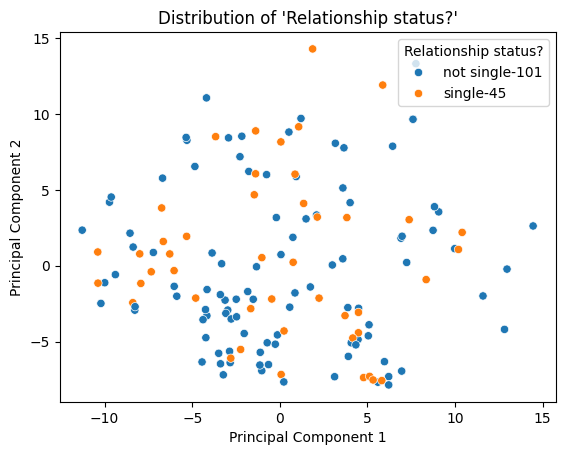

In [35]:
current_question = "single"
signify = question_significance[current_question]
pca_df[signify] = list(filtered_df[current_question])
value_counts = pca_df[signify].value_counts()
pca_df[signify] = pca_df[signify].apply(update_values(value_counts))
# Create a scatter plot using Seaborn
sns.scatterplot(x='dim1', y='dim2', data=pca_df, hue = signify)
plt.title(f"Distribution of '{signify}'")
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [36]:
filtered_df

,friend_of,table,single,seating_question_1,seating_question_2,seating_question_3,seating_question_4,seating_question_5,seating_question_6,seating_question_7,seating_question_8,seating_question_9,seating_question_10
0,mat,1,not single,paprika,charmander,gryffondor,browncafe,wine,aliens,pepper,spices,france,math
1,mat,0,not single,paprika,squirtle,huffelpuf,clubbing,tea,ghost,chocolate,icecream,unitedkingdom,math
2,liv,1,not single,salt,squirtle,gryffondor,browncafe,wine,aliens,chocolate,icecream,unitedkingdom,liv
3,mat,0,not single,salt,bulbasaur,huffelpuf,browncafe,beer,aliens,pistachio,spices,unitedkingdom,math
4,mat,1,not single,paprika,squirtle,gryffondor,browncafe,beer,nessie,chocolate,icecream,france,liv
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,liv,0,not single,paprika,charmander,huffelpuf,clubbing,beer,ghost,chocolate,sex,unitedkingdom,math
101,liv,0,not single,salt,charmander,slitherin,clubbing,beer,reptilian,chocolate,icecream,netherlands,liv
160,liv,0,not single,salt,charmander,gryffondor,browncafe,wine,ghost,pistachio,sex,france,liv
200,mat,3,not single,salt,charmander,gryffondor,browncafe,gin,aliens,pepper,spices,france,liv


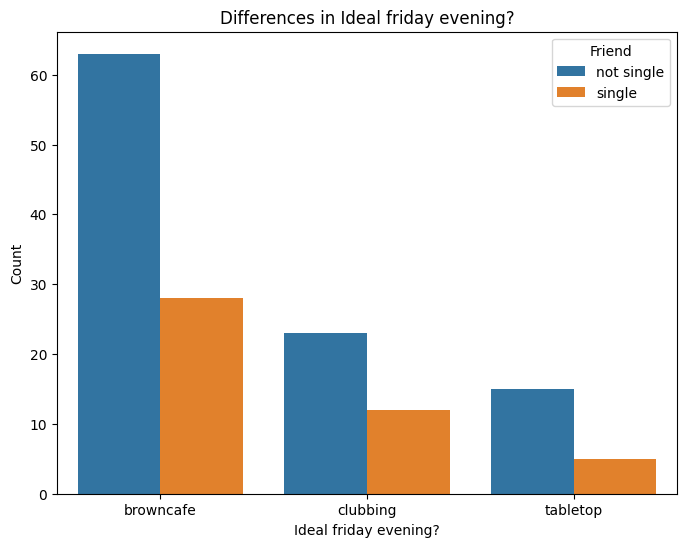

In [37]:
questionsy = 'seating_question_4'
# Assuming your DataFrame is named df
# Filter the DataFrame for friends 'mat' and 'liv'
temp = filtered_df[filtered_df['friend_of'].isin(['mat', 'liv'])]

# Create the countplot
plt.figure(figsize=(8, 6))
sns.countplot(data=temp, x=questionsy, hue='single')

# Set labels and title
plt.xlabel(f"{question_significance[questionsy]}")
plt.ylabel('Count')
plt.title(f"Differences in {question_significance[questionsy]}")

# Show plot
plt.legend(title='Friend')
plt.show()

# Run UMAP

In [38]:
# Run UMAP
reducer = umap.UMAP(n_components=nr_lower_dims)
embedding = reducer.fit_transform(one_hot_encoded)

In [39]:
# Create a new DataFrame to store the principal components
umap_df = pd.DataFrame(data=embedding, columns=lower_dims_labels)

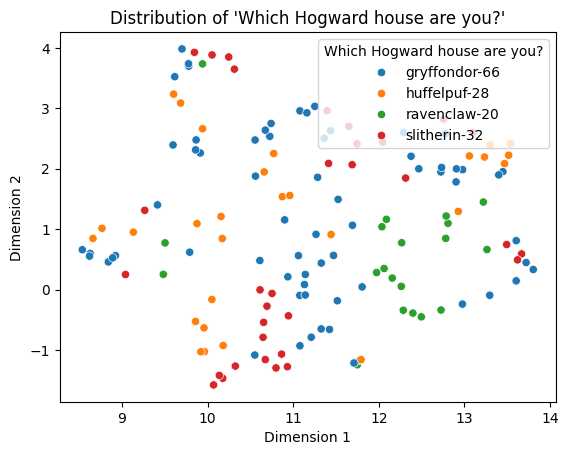

In [44]:
current_question = "seating_question_3"
signify = question_significance[current_question]
umap_df[signify] = list(filtered_df[current_question])
value_counts = umap_df[signify].value_counts()
umap_df[signify] = umap_df[signify].apply(update_values(value_counts))
# Create a scatter plot using Seaborn
sns.scatterplot(x='dim1', y='dim2', data=umap_df, hue = signify)
plt.title(f"Distribution of '{signify}'")
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

In [41]:
needed_later

,name,email,name .1,family_name,has_answered_form,answer_friday,answer_diner,answer_ceremony,answer_reception,plusones,...,seating_question_10,seating_question_11,seating_question_12,seating_question_13,seating_question_14,seating_question_15,Sex,friend_of,table,single
0,Pierre,pietdel@gmail.com,Pierre,Delacroix,yes,no,yes,no,yes,,...,10_love_math,,,,,,male,10_mat,1,not single
1,Caroline,carolinewvh@gmail.com,Caroline,Wesselman van Helmond,yes,no,yes,no,yes,leonore.vehmeijer@gmail.com,...,10_love_math,,,,,,female,10_mat,0,not single
2,Erica,erica.efst@gmail.com,Erica,Efstratoudakis,yes,yes,yes,yes,yes,aamoratis@gmail.com,...,10_love_liv,,,,,,female,10_liv,1,not single
3,Darren,darrenmk1@gmail.com,Darren,Kripaitis,yes,no,yes,yes,yes,,...,10_love_math,,,,,,male,10_mat,0,not single
4,Charles-Henri,ch.starckmann@gmail.com,Charles-Henri,Starckmann,yes,no,yes,no,yes,,...,10_love_liv,,,,,,male,10_mat,1,not single
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,Robert,vdlindenrj@gmail.com,Robert,van der Linden,yes,no,yes,yes,yes,,...,10_love_math,,,,,,male,10_liv,0,not single
101,Xenia,popowskixenia@gmail.com,Xenia,,yes,no,yes,yes,yes,,...,10_love_liv,,,,,,female,10_liv,0,not single
160,Zarah & Duco,duco@duna.io,Zarah & Duco,van Lanschot - Abeln,yes,no,yes,yes,yes,,...,10_love_liv,,,,,,male,10_liv,0,not single
200,BigNickkk,bignick@blasband.com,BigNickkk,Blasband,yes,no,yes,no,no,,...,10_love_liv,,,,,,male,10_mat,3,not single


# Divide into red and blue

In [61]:
import pandas as pd
from sklearn.cluster import KMeans

# Assuming 'embedding' and 'lower_dims_labels' are defined elsewhere
umap_df = pd.DataFrame(data=embedding, columns=lower_dims_labels)
umap_df['Sex'] = list(needed_later['Sex'])

# Preprocess the data by encoding 'Sex' column to numerical values
umap_df['Sex'] = umap_df['Sex'].map({'male': 0, 'female': 1})

# Define the number of clusters (2 in this case)
n_clusters = 2

# Fit K-means clustering model
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
umap_df['cluster'] = kmeans.fit_predict(umap_df[['dim1', 'dim2', 'Sex']])

# Calculate the number of males and females in each cluster
cluster_sex_counts = umap_df.groupby('cluster')['Sex'].value_counts().unstack(fill_value=0)

# Ensure approximately the same male/female ratio in each cluster
cluster_sex_counts = cluster_sex_counts.apply(lambda x: x / x.sum(), axis=1)
umap_df['cluster'] = umap_df['cluster'].map(cluster_sex_counts.idxmin(axis=1))

# Combine 'Sex' and 'cluster' to create 'groups' column
umap_df['groups'] = umap_df.apply(lambda row: 'blue_male' if row['Sex'] == 0 and row['cluster'] == 1 else
                                             'blue_female' if row['Sex'] == 1 and row['cluster'] == 1 else
                                             'red_male' if row['Sex'] == 0 and row['cluster'] == 0 else
                                             'red_female' if row['Sex'] == 1 and row['cluster'] == 0 else '', axis=1)

# Calculate counts of each group
group_counts = umap_df['groups'].value_counts()

# Update 'groups' column with counts
umap_df['groups'] = umap_df.apply(lambda row: f"blue_male_{group_counts.get('blue_male', 0)}" if row['groups'] == 'blue_male' else
                                               f"blue_female_{group_counts.get('blue_female', 0)}" if row['groups'] == 'blue_female' else
                                               f"red_male_{group_counts.get('red_male', 0)}" if row['groups'] == 'red_male' else
                                               f"red_female_{group_counts.get('red_female', 0)}" if row['groups'] == 'red_female' else '', axis=1)

# Print the resulting DataFrame
print(umap_df)


          dim1      dim2  Sex  cluster          groups
0    11.515808 -0.186512    0        1    blue_male_40
1    10.156863  1.209209    1        1  blue_female_29
2    11.266622  0.913933    1        1  blue_female_29
3     9.859144 -0.528916    0        1    blue_male_40
4    12.467426  1.999292    0        0     red_male_31
..         ...       ...  ...      ...             ...
141  10.661207  1.947020    0        0     red_male_31
142   9.846021  3.927227    1        0   red_female_46
143  10.674198  2.639253    0        0     red_male_31
144  11.710123 -1.216403    0        1    blue_male_40
145  10.900215  1.153242    1        0   red_female_46

[146 rows x 5 columns]


/home/mat2m10/miniconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


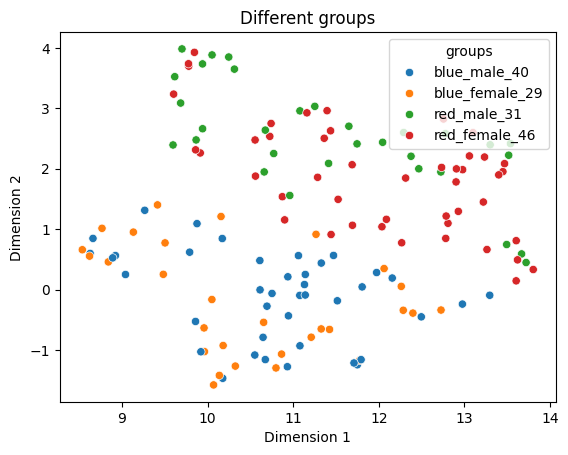

In [62]:
# Create a scatter plot using Seaborn
sns.scatterplot(x='dim1', y='dim2', data=umap_df, hue = 'groups')
plt.title(f"Different groups")
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

In [64]:
group_counts

groups
red_female     46
blue_male      40
red_male       31
blue_female    29
Name: count, dtype: int64

In [67]:
if group_counts.red_female > group_counts.blue_female:
    to_transfer_fem = 'red_female'
    nr_to_transfer_fem = (group_counts.red_female - group_counts.blue_female)//2
    
else:
    to_transfer_fem = 'blue_female'
    nr_to_transfer_fem = (group_counts.blue_female - group_counts.red_female)//2

if group_counts.red_male > group_counts.blue_male:
    to_transfer_male = 'red_male'
    nr_to_transfer_male = (group_counts.red_male - group_counts.blue_male)//2
else:
    to_transfer_male = 'blue_male'
    nr_to_transfer_male = (group_counts.blue_male - group_counts.red_male)//2

In [69]:
to_transfer_male

'blue_male'

In [70]:
nr_to_transfer_male

4

In [72]:
to_transfer_fem

'red_female'

In [73]:
nr_to_transfer_fem

8

# Cluster pairs

In [42]:
nr_lower_dim = nr_lower_dims # based on how many dims you calculate the distance
lower_dims_labels = [f"dim{i}" for i in range(1, nr_lower_dims + 1)]

In [43]:
#chosen_dim = umap_df[lower_dims_labels] # choose umap or PCA (or others)
chosen_dim = umap_df[lower_dims_labels] # choose umap or PCA (or others)
chosen_dim['gender'] = list(needed_later['Sex'])
chosen_dim['email'] = list(needed_later['email'])

In [44]:
gender_counts = chosen_dim['gender'].value_counts()
if gender_counts.female >= gender_counts.male:
    most_present = "female"
else:
    most_present = "male"

In [45]:
gender_counts.female

74

In [46]:
gender_counts.male

71

In [47]:
most_present

'female'

In [48]:
if most_present == 'female':
    least_present = 'male'
    starting_df = chosen_dim[chosen_dim['gender']=='male'][lower_dims_labels+['email']]
    overschot = chosen_dim[chosen_dim['gender']=='female'][lower_dims_labels+['email']]
else:
    least_present = 'female'
    overschot = chosen_dim[chosen_dim['gender']=='male'][lower_dims_labels+['email']]
    starting_df = chosen_dim[chosen_dim['gender']=='female'][lower_dims_labels+['email']]

In [49]:
extraction = one_hot_encoded.copy()
extraction['email'] = list(needed_later['email'])
extraction['name'] = list(needed_later['name'])
extraction['family_name'] = list(needed_later['family_name'])
columns = extraction.columns.tolist()
new_columns = columns[-3:] + columns[:-3]
extraction = extraction[new_columns]

matching_pairs_one_hot = []
matching_pairs_emails = []

nn = NearestNeighbors(n_neighbors=1, algorithm='auto')
starting_df = starting_df.sample(frac=1).reset_index(drop=True)

while len(starting_df) > 0:
    df1 = starting_df.head(1)
    df2 = overschot
    # Convert pandas DataFrames to numpy arrays
    df1_array = df1[lower_dims_labels].to_numpy()
    df2_array = df2[lower_dims_labels].to_numpy()
    df2_to_read = df2.to_numpy()

    # Flatten the arrays to 2D
    df1_flat = df1_array.reshape(len(df1_array), -1)
    df2_flat = df2_array.reshape(len(df2_array), -1)
    df2_to_read_flat = df2_to_read.reshape(len(df2_to_read), -1)

    nn.fit(df2_flat)
    distances, indices = nn.kneighbors(df1_flat)

    email_overschot = extract_email(df2_to_read_flat[indices])
    email_init = list(df1.email)[0]

    starting_df = starting_df[starting_df['email'] != email_init]
    overschot = overschot[overschot['email'] != email_overschot]

    couple = extraction[(extraction['email'] == email_overschot) | (extraction['email'] == email_init)]
    couple_additional_info = chosen_dim[(chosen_dim['email'] == email_overschot) | (chosen_dim['email'] == email_init)]
    merged_df = pd.merge(couple_additional_info, couple, on='email')
    columns = merged_df.columns.tolist()
    new_columns = merged_df.columns[3:6].tolist() + [col for col in columns if col not in merged_df.columns[3:6]]
    couple = merged_df[new_columns]

    matching_pairs_one_hot.append(couple)
    matching_pairs_emails.append([email_init,email_overschot])

In [50]:
matching_pairs_emails_df = pd.DataFrame(matching_pairs_emails, columns = [f"email {least_present}",f"email {most_present}"])
matching_pairs_emails_df

,email male,email female
0,leo.nassiri@gmail.com,laure.w@gmail.com
1,matthieu.dehemptinne@gmail.com,liviadeguerre@gmail.com
2,thom.hendriks@gmail.com,avanvolsem@hotmail.com
3,adelin.philippe@gmail.com,l.h.devries@outlook.com
4,nicolasgodart@hotmail.com,celestinedec@gmail.com
...,...,...
66,leopold.gerard@gmail.com,marie.vdhoeven@gmail.com
67,h.p.wynaendts@gmail.com,svanberckel@hotmail.com
68,gj.oudewesselink@gmail.com,c.carak@gmail.com
69,alexsvo@me.com,freedom-22@hotmail.co.uk


# Re-run for overschot

In [51]:
if most_present == 'female':
    least_present = 'male'
    starting_df = overschot
    overschot = chosen_dim[chosen_dim['gender']=='male'][lower_dims_labels+['email']]
else:
    least_present = 'female'
    starting_df = overschot
    overschot = chosen_dim[chosen_dim['gender']=='female'][lower_dims_labels+['email']]

In [52]:
matching_pairs_overschot_one_hot = []
matching_pairs_overschot_emails = []
starting_df = starting_df.sample(frac=1).reset_index(drop=True)
while len(starting_df) > 0:
    df1 = starting_df.head(1)
    df2 = overschot
    # Convert pandas DataFrames to numpy arrays
    df1_array = df1[lower_dims_labels].to_numpy()
    df2_array = df2[lower_dims_labels].to_numpy()
    df2_to_read = df2.to_numpy()

    # Flatten the arrays to 2D
    df1_flat = df1_array.reshape(len(df1_array), -1)
    df2_flat = df2_array.reshape(len(df2_array), -1)
    df2_to_read_flat = df2_to_read.reshape(len(df2_to_read), -1)

    nn.fit(df2_flat)
    distances, indices = nn.kneighbors(df1_flat)

    email_overschot = extract_email(df2_to_read_flat[indices])
    email_init = list(df1.email)[0]

    starting_df = starting_df[starting_df['email'] != email_init]
    overschot = overschot[overschot['email'] != email_overschot]

    couple = extraction[(extraction['email'] == email_overschot) | (extraction['email'] == email_init)]
    couple_additional_info = chosen_dim[(chosen_dim['email'] == email_overschot) | (chosen_dim['email'] == email_init)]
    merged_df = pd.merge(couple_additional_info, couple, on='email')
    columns = merged_df.columns.tolist()
    new_columns = merged_df.columns[3:6].tolist() + [col for col in columns if col not in merged_df.columns[3:6]]
    couple = merged_df[new_columns]

    matching_pairs_overschot_one_hot.append(couple)
    matching_pairs_overschot_emails.append([email_init,email_overschot])

In [53]:
matching_pairs_overschot_emails_df = pd.DataFrame(matching_pairs_overschot_emails, columns = [f"email {most_present} overschot",f"email {least_present}"])
matching_pairs_overschot_emails_df

,email female overschot,email male
0,paulineranscelot@gmail.com,matthijsdekempenaer@gmail.com
1,annadansembourg@gmail.com,harold.delacroix@gmail.com
2,ohman.molly@gmail.com,thom.hendriks@gmail.com


In [54]:
similarity_groups = pd.merge(matching_pairs_emails_df, matching_pairs_overschot_emails_df, on=f"email {least_present}", how="outer")
similarity_groups

,email male,email female,email female overschot
0,leo.nassiri@gmail.com,laure.w@gmail.com,NaN
1,matthieu.dehemptinne@gmail.com,liviadeguerre@gmail.com,NaN
2,thom.hendriks@gmail.com,avanvolsem@hotmail.com,ohman.molly@gmail.com
3,adelin.philippe@gmail.com,l.h.devries@outlook.com,NaN
4,nicolasgodart@hotmail.com,celestinedec@gmail.com,NaN
...,...,...,...
66,leopold.gerard@gmail.com,marie.vdhoeven@gmail.com,NaN
67,h.p.wynaendts@gmail.com,svanberckel@hotmail.com,NaN
68,gj.oudewesselink@gmail.com,c.carak@gmail.com,NaN
69,alexsvo@me.com,freedom-22@hotmail.co.uk,NaN


# Recompressing for anti-pairs

In [55]:
extraction

,email,name,family_name,friend_of_liv,friend_of_mat,table_0,table_1,table_2,table_3,single_not single,...,seating_question_7_vanilla,seating_question_8_icecream,seating_question_8_sex,seating_question_8_spices,seating_question_9_france,seating_question_9_germany,seating_question_9_netherlands,seating_question_9_unitedkingdom,seating_question_10_liv,seating_question_10_math
0,pietdel@gmail.com,Pierre,Delacroix,-0.0,0.0,-5.038950,5.637629,-0.523262,-0.606349,1.207477,...,-0.450443,-1.510381,-0.798228,2.430278,2.188122,-0.544331,-0.8,-1.428869,-1.260669,1.260669
1,carolinewvh@gmail.com,Caroline,Wesselman van Helmond,-0.0,0.0,2.571964,-2.298839,-0.523262,-0.606349,1.207477,...,-0.450443,1.489691,-0.798228,-0.925820,-1.828051,-0.544331,-0.8,2.799417,-1.260669,1.260669
2,erica.efst@gmail.com,Erica,Efstratoudakis,0.0,-0.0,-5.038950,5.637629,-0.523262,-0.606349,1.207477,...,-0.450443,1.489691,-0.798228,-0.925820,-1.828051,-0.544331,-0.8,2.799417,0.793230,-0.793230
3,darrenmk1@gmail.com,Darren,Kripaitis,-0.0,0.0,2.571964,-2.298839,-0.523262,-0.606349,1.207477,...,-0.450443,-1.510381,-0.798228,2.430278,-1.828051,-0.544331,-0.8,2.799417,-1.260669,1.260669
4,ch.starckmann@gmail.com,Charles-Henri,Starckmann,-0.0,0.0,-5.038950,5.637629,-0.523262,-0.606349,1.207477,...,-0.450443,1.489691,-0.798228,-0.925820,2.188122,-0.544331,-0.8,-1.428869,0.793230,-0.793230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,vdlindenrj@gmail.com,Robert,van der Linden,0.0,-0.0,2.571964,-2.298839,-0.523262,-0.606349,1.207477,...,-0.450443,-1.510381,-0.798228,2.430278,-1.828051,-0.544331,-0.8,2.799417,-1.260669,1.260669
141,popowskixenia@gmail.com,Xenia,,0.0,-0.0,2.571964,-2.298839,-0.523262,-0.606349,1.207477,...,-0.450443,1.489691,-0.798228,-0.925820,2.188122,-0.544331,-0.8,-1.428869,0.793230,-0.793230
142,duco@duna.io,Zarah & Duco,van Lanschot - Abeln,0.0,-0.0,2.571964,-2.298839,-0.523262,-0.606349,1.207477,...,-0.450443,1.489691,-0.798228,-0.925820,2.188122,-0.544331,-0.8,-1.428869,0.793230,-0.793230
143,bignick@blasband.com,BigNickkk,Blasband,-0.0,0.0,-5.038950,-2.298839,-0.523262,21.373816,1.207477,...,-0.450443,-1.510381,-0.798228,2.430278,-1.828051,-0.544331,5.0,-1.428869,0.793230,-0.793230


In [56]:
similarity_groups

,email male,email female,email female overschot
0,leo.nassiri@gmail.com,laure.w@gmail.com,NaN
1,matthieu.dehemptinne@gmail.com,liviadeguerre@gmail.com,NaN
2,thom.hendriks@gmail.com,avanvolsem@hotmail.com,ohman.molly@gmail.com
3,adelin.philippe@gmail.com,l.h.devries@outlook.com,NaN
4,nicolasgodart@hotmail.com,celestinedec@gmail.com,NaN
...,...,...,...
66,leopold.gerard@gmail.com,marie.vdhoeven@gmail.com,NaN
67,h.p.wynaendts@gmail.com,svanberckel@hotmail.com,NaN
68,gj.oudewesselink@gmail.com,c.carak@gmail.com,NaN
69,alexsvo@me.com,freedom-22@hotmail.co.uk,NaN


In [57]:
col_male = [name + "_male" for name in extraction.columns[3:]]
col_female = [name + "_female" for name in extraction.columns[3:]]
combined_headers = col_male + col_female

In [58]:
combined_arrays = []
for index, row in similarity_groups.iterrows():
    # Access row data using row['column_name'] or row[column_index]
    exctract_male = extraction[extraction['email'] == row[f"email {least_present}"]]
    exctract_female = extraction[extraction['email'] == row[f"email {most_present}"]]
    exctract_male_values = exctract_male.iloc[0].values[3:]
    exctract_female_values = exctract_female.iloc[0].values[3:]
    combined_values = list(exctract_male_values) + list(exctract_female_values)
    combined_arrays.append(combined_values)

In [59]:
lovers = pd.DataFrame(combined_arrays, columns = combined_headers)
lovers

,friend_of_liv_male,friend_of_mat_male,table_0_male,table_1_male,table_2_male,table_3_male,single_not single_male,single_single_male,seating_question_1_paprika_male,seating_question_1_salt_male,...,seating_question_7_vanilla_female,seating_question_8_icecream_female,seating_question_8_sex_female,seating_question_8_spices_female,seating_question_9_france_female,seating_question_9_germany_female,seating_question_9_netherlands_female,seating_question_9_unitedkingdom_female,seating_question_10_liv_female,seating_question_10_math_female
0,-0.0,0.0,-5.038950,-2.298839,-0.523262,21.373816,1.207477,-1.207477,0.762268,-0.762268,...,-0.450443,1.489691,-0.798228,-0.925820,2.188122,-0.544331,-0.8,-1.428869,-1.260669,1.260669
1,-0.0,0.0,-5.038950,5.637629,-0.523262,-0.606349,1.207477,-1.207477,0.762268,-0.762268,...,-0.450443,-1.510381,2.818743,-0.925820,-1.828051,-0.544331,-0.8,2.799417,0.793230,-0.793230
2,0.0,-0.0,2.571964,-2.298839,-0.523262,-0.606349,1.207477,-1.207477,0.762268,-0.762268,...,-0.450443,-1.510381,-0.798228,2.430278,2.188122,-0.544331,-0.8,-1.428869,-1.260669,1.260669
3,-0.0,0.0,2.571964,-2.298839,-0.523262,-0.606349,-2.683282,2.683282,0.762268,-0.762268,...,-0.450443,1.489691,-0.798228,-0.925820,-1.828051,-0.544331,5.0,-1.428869,0.793230,-0.793230
4,-0.0,0.0,2.571964,-2.298839,-0.523262,-0.606349,1.207477,-1.207477,-0.839600,0.839600,...,-0.450443,-1.510381,-0.798228,2.430278,2.188122,-0.544331,-0.8,-1.428869,-1.260669,1.260669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,-0.0,0.0,-5.038950,5.637629,-0.523262,-0.606349,1.207477,-1.207477,-0.839600,0.839600,...,-0.450443,1.489691,-0.798228,-0.925820,2.188122,-0.544331,-0.8,-1.428869,0.793230,-0.793230
67,0.0,-0.0,2.571964,-2.298839,-0.523262,-0.606349,-2.683282,2.683282,-0.839600,0.839600,...,-0.450443,-1.510381,2.818743,-0.925820,-1.828051,-0.544331,-0.8,2.799417,0.793230,-0.793230
68,0.0,-0.0,2.571964,-2.298839,-0.523262,-0.606349,1.207477,-1.207477,-0.839600,0.839600,...,-0.450443,1.489691,-0.798228,-0.925820,-1.828051,-0.544331,-0.8,2.799417,-1.260669,1.260669
69,0.0,-0.0,2.571964,-2.298839,-0.523262,-0.606349,1.207477,-1.207477,-0.839600,0.839600,...,-0.450443,1.489691,-0.798228,-0.925820,-1.828051,-0.544331,-0.8,2.799417,-1.260669,1.260669


# ReRun PCA

In [60]:
nr_lower_dims = 15
lower_dims_labels = [f"dim{i}" for i in range(1, nr_lower_dims + 1)]
pca = PCA(n_components=nr_lower_dims)

# Fit the PCA model to your one-hot encoded DataFrame
pca.fit(lovers)

# Transform the data to its principal components
pca_result = pca.transform(lovers)

# Create a new DataFrame to store the principal components
pca_df = pd.DataFrame(data=pca_result, columns=lower_dims_labels)

# ReRun UMAP

In [61]:
# Run UMAP
reducer = umap.UMAP(n_components=nr_lower_dims)
embedding = reducer.fit_transform(lovers)
# Create a new DataFrame to store the principal components
umap_df = pd.DataFrame(data=embedding, columns=lower_dims_labels)

# Create Nemesis clusters

In [62]:
nr_lower_dim = nr_lower_dims # based on how many dims you calculate the distance
lower_dims_labels = [f"dim{i}" for i in range(1, nr_lower_dims + 1)]

In [63]:
#chosen_dim = umap_df[lower_dims_labels] # choose umap or PCA (or others)
chosen_dim = umap_df[lower_dims_labels] # choose umap or PCA (or others)

In [64]:
similarity_groups

,email male,email female,email female overschot
0,leo.nassiri@gmail.com,laure.w@gmail.com,NaN
1,matthieu.dehemptinne@gmail.com,liviadeguerre@gmail.com,NaN
2,thom.hendriks@gmail.com,avanvolsem@hotmail.com,ohman.molly@gmail.com
3,adelin.philippe@gmail.com,l.h.devries@outlook.com,NaN
4,nicolasgodart@hotmail.com,celestinedec@gmail.com,NaN
...,...,...,...
66,leopold.gerard@gmail.com,marie.vdhoeven@gmail.com,NaN
67,h.p.wynaendts@gmail.com,svanberckel@hotmail.com,NaN
68,gj.oudewesselink@gmail.com,c.carak@gmail.com,NaN
69,alexsvo@me.com,freedom-22@hotmail.co.uk,NaN


In [65]:
most_present

'female'

In [66]:
chosen_dim[f"email {least_present}"] = list(similarity_groups[f"email {least_present}"])
chosen_dim[f"email {most_present}"] = list(similarity_groups[f"email {most_present}"])
chosen_dim[f"email {most_present} overschot"] = list(similarity_groups[f"email {most_present} overschot"])

In [67]:
starting_df = chosen_dim.copy()
nemesises = []
while len(starting_df) > 0:
    try:
        starting_df = starting_df.sample(frac=1).reset_index(drop=True)

        # Check if DataFrame is not empty after shuffling
        if len(starting_df) == 0:
            break
        
        good = [starting_df.iloc[0][f"email {least_present}"],
                starting_df.iloc[0][f"email {most_present}"],
                starting_df.iloc[0][f"email {most_present} overschot"]]
        data = starting_df[lower_dims_labels].values
        distances = euclidean_distances(data, [data[0]])
        index_max_distance = distances.argmax()
        bad = [starting_df.iloc[index_max_distance][f"email {least_present}"],
               starting_df.iloc[index_max_distance][f"email {most_present}"],
                starting_df.iloc[index_max_distance][f"email {most_present} overschot"]]
        
        
        starting_df = starting_df[starting_df[f"email {least_present}"] != good[0]]
        starting_df = starting_df[starting_df[f"email {least_present}"] != bad[0]]
        nemesises.append(good + bad)
    except Exception as e:
        print(e)
        overschot_nemesis = starting_df.copy()

# People without pairs

In [68]:
starting_df

,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,dim11,dim12,dim13,dim14,dim15,email male,email female,email female overschot


In [69]:
cols = [f"{least_present} good", f"{most_present} good", f"{most_present} overschot good", f"{least_present} bad", f"{most_present} bad", f"{most_present} overschot bad"]

In [70]:
nemesises = pd.DataFrame(data = nemesises, columns = cols)
nemesises

,male good,female good,female overschot good,male bad,female bad,female overschot bad
0,thom.hendriks@gmail.com,avanvolsem@hotmail.com,ohman.molly@gmail.com,alexis.philippartdefoy@gmail.com,ines.haitsma@gmail.com,NaN
1,h.p.wynaendts@gmail.com,svanberckel@hotmail.com,NaN,maxime@paternotte.com,leaverdoodt@gmail.com,NaN
2,charko.doultremont@gmail.com,tuanabukemyildiz@gmail.com,NaN,matthijsdekempenaer@gmail.com,theresaisabelkruse@gmail.com,paulineranscelot@gmail.com
3,harold.loop@gmail.com,carolinewvh@gmail.com,NaN,harold.delacroix@gmail.com,sophiewynaendts@gmail.com,annadansembourg@gmail.com
4,eberhard@redrink.co,a.k.greul@gmail.com,NaN,henrydetraux@gmail.com,amelboes@hotmail.com,NaN
5,j.siegelmann@me.com,intratorc@gmail.com,NaN,francoisboulange@gmail.com,adeguerre146@hotmail.com,NaN
6,jdursel@gmail.com,n.z.borren@gmail.com,NaN,vdlindenrj@gmail.com,hortensevincotte@gmail.com,NaN
7,thomasdeguerre@gmail.com,vandenbulcke.cha@gmail.com,NaN,matthieu.dehemptinne@gmail.com,liviadeguerre@gmail.com,NaN
8,augustinvde@hotmail.com,alinefadie@gmail.com,NaN,khosrowshahidara@gmail.com,jiuliadansembourg@gmail.com,NaN
9,francois.m.joris@gmail.com,mariettebalder@gmail.com,NaN,ch.starckmann@gmail.com,annesophievv@hotmail.com,NaN


# Make tables

In [102]:
combined_arrays = []
for index, row in nemesises.iterrows():
    exctract_male_good = extraction[extraction['email'] == row[f"{least_present} good"]]
    exctract_male_good_values = exctract_male_good.iloc[0].values[3:]
    exctract_female_good = extraction[extraction['email'] == row[f"{most_present} good"]]
    exctract_female_good_values = exctract_female_good.iloc[0].values[3:]

    exctract_male_bad = extraction[extraction['email'] == row[f"{least_present} bad"]]
    exctract_male_bad_values = exctract_male_bad.iloc[0].values[3:]
    exctract_female_bad = extraction[extraction['email'] == row[f"{most_present} bad"]]
    exctract_female_bad_values = exctract_female_bad.iloc[0].values[3:]

    combined_values = list(exctract_male_good_values) + list(exctract_female_good_values) + list(exctract_male_bad_values) + list(exctract_female_bad_values)
    combined_arrays.append(combined_values)

In [103]:
col_male_good = [name + "_male_good" for name in extraction.columns[3:]]
col_female_good = [name + "_female_good" for name in extraction.columns[3:]]
col_male_good_bad = [name + "_male_bad" for name in extraction.columns[3:]]
col_female_good_bad = [name + "_female_bad" for name in extraction.columns[3:]]
combined_headers = col_male_good + col_female_good + col_male_good_bad + col_female_good_bad

In [104]:
tables = pd.DataFrame(combined_arrays, columns = combined_headers)
tables

,friend_of_liv_male_good,friend_of_mat_male_good,table_0_male_good,table_1_male_good,table_2_male_good,table_3_male_good,single_not single_male_good,single_single_male_good,seating_question_1_paprika_male_good,seating_question_1_salt_male_good,...,seating_question_7_vanilla_female_bad,seating_question_8_icecream_female_bad,seating_question_8_sex_female_bad,seating_question_8_spices_female_bad,seating_question_9_france_female_bad,seating_question_9_germany_female_bad,seating_question_9_netherlands_female_bad,seating_question_9_unitedkingdom_female_bad,seating_question_10_liv_female_bad,seating_question_10_math_female_bad
0,-0.0,0.0,-5.012637,5.610195,-0.525114,-0.608511,1.213560,-1.213560,0.756724,-0.756724,...,-0.452084,1.479309,-0.801784,-0.914174,-1.865615,-0.546358,-0.779744,2.828427,-1.235442,1.235442
1,-0.0,0.0,2.585465,-2.310080,-0.525114,-0.608511,1.213560,-1.213560,0.756724,-0.756724,...,-0.452084,1.479309,-0.801784,-0.914174,2.144065,-0.546358,-0.779744,-1.414214,0.809427,-0.809427
2,-0.0,0.0,2.585465,-2.310080,-0.525114,-0.608511,1.213560,-1.213560,0.756724,-0.756724,...,-0.452084,-1.520980,-0.801784,2.461238,-1.865615,-0.546358,5.129892,-1.414214,0.809427,-0.809427
3,-0.0,0.0,-5.012637,5.610195,-0.525114,-0.608511,-2.669831,2.669831,-0.845751,0.845751,...,-0.452084,-1.520980,2.806243,-0.914174,-1.865615,-0.546358,5.129892,-1.414214,0.809427,-0.809427
4,-0.0,0.0,2.585465,-2.310080,-0.525114,-0.608511,1.213560,-1.213560,-0.845751,0.845751,...,-0.452084,1.479309,-0.801784,-0.914174,2.144065,-0.546358,-0.779744,-1.414214,-1.235442,1.235442
5,0.0,-0.0,2.585465,-2.310080,-0.525114,-0.608511,1.213560,-1.213560,0.756724,-0.756724,...,-0.452084,1.479309,-0.801784,-0.914174,2.144065,-0.546358,-0.779744,-1.414214,-1.235442,1.235442
6,-0.0,0.0,-5.012637,-2.310080,24.680357,-0.608511,1.213560,-1.213560,0.756724,-0.756724,...,-0.452084,1.479309,-0.801784,-0.914174,2.144065,-0.546358,-0.779744,-1.414214,0.809427,-0.809427
7,0.0,-0.0,2.585465,-2.310080,-0.525114,-0.608511,1.213560,-1.213560,0.756724,-0.756724,...,-0.452084,1.479309,-0.801784,-0.914174,-1.865615,-0.546358,-0.779744,2.828427,0.809427,-0.809427
8,0.0,-0.0,2.585465,-2.310080,-0.525114,-0.608511,-2.669831,2.669831,-0.845751,0.845751,...,-0.452084,-1.520980,2.806243,-0.914174,2.144065,-0.546358,-0.779744,-1.414214,0.809427,-0.809427
9,-0.0,0.0,-5.012637,5.610195,-0.525114,-0.608511,-2.669831,2.669831,0.756724,-0.756724,...,-0.452084,1.479309,-0.801784,-0.914174,-1.865615,7.321202,-0.779744,-1.414214,0.809427,-0.809427


In [108]:
table_names_and_sizes = {
    "goldstrike":38,
    "tequila":12,
    "jagermeister":12,
    "liquer43":14,
    "salmari":14,
    "limoncello":14,
    "cointreau":12,
    "peardrop":12,
    "curacao":12,
    "genepi":10,
    "absynth":9
}

nr_of_tables = len(table_names_and_sizes)
nr_of_tables

11

In [109]:
total = sum(table_names_and_sizes.values())
total

159

In [111]:
needed_later

,name,email,name .1,family_name,has_answered_form,answer_friday,answer_diner,answer_ceremony,answer_reception,plusones,...,seating_question_10,seating_question_11,seating_question_12,seating_question_13,seating_question_14,seating_question_15,Sex,friend_of,table,single
0,Pierre,pietdel@gmail.com,Pierre,Delacroix,yes,no,yes,no,yes,,...,10_love_math,,,,,,male,10_mat,1,not single
1,Caroline,carolinewvh@gmail.com,Caroline,Wesselman van Helmond,yes,no,yes,no,yes,leonore.vehmeijer@gmail.com,...,10_love_math,,,,,,female,10_mat,0,not single
2,Erica,erica.efst@gmail.com,Erica,Efstratoudakis,yes,yes,yes,yes,yes,aamoratis@gmail.com,...,10_love_liv,,,,,,female,10_liv,1,not single
3,Darren,darrenmk1@gmail.com,Darren,Kripaitis,yes,no,yes,yes,yes,,...,10_love_math,,,,,,male,10_mat,0,not single
4,Charles-Henri,ch.starckmann@gmail.com,Charles-Henri,Starckmann,yes,no,yes,no,yes,,...,10_love_liv,,,,,,male,10_mat,1,not single
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,Robert,vdlindenrj@gmail.com,Robert,van der Linden,yes,no,yes,yes,yes,,...,10_love_liv,,,,,,male,10_liv,0,not single
101,Xenia,popowskixenia@gmail.com,Xenia,,yes,no,yes,yes,yes,,...,10_love_math,,,,,,female,10_liv,0,not single
160,Zarah & Duco,duco@duna.io,Zarah & Duco,van Lanschot - Abeln,yes,no,yes,yes,yes,,...,10_love_math,,,,,,male,10_liv,0,not single
200,BigNickkk,bignick@blasband.com,BigNickkk,Blasband,yes,no,yes,no,no,,...,10_love_math,,,,,,male,10_mat,3,not single


In [113]:
for element in np.sort(list(needed_later['email'])):
    print(element)

a.k.greul@gmail.com
aamoratis@gmail.com
adefoestraets@gmail.com
adeguerre146@hotmail.com
adelin.philippe@gmail.com
alexander.schwennicke@gmail.com
alexdehemptinne90@gmail.com
alexis.latinis@hotmail.com
alexis.philippartdefoy@gmail.com
alexr89@hotmail.fr
alexsvo@me.com
ali@digitalpark.be
alice.athanassiadis@gmail.com
alice.j.sommer@gmail.com
alinefadie@gmail.com
amelboes@hotmail.com
amelie.thibautdem@gmail.com
amiel.hadrien@gmail.com
amvaneden@gmail.com
annadansembourg@gmail.com
annesophievv@hotmail.com
arnaud.decleve0807@gmail.com
augustinvde@hotmail.com
avanvolsem@hotmail.com
bencibea@gmail.com
bergmansmartin2@hotmail.com
bertichat@gmail.com
bignick@blasband.com
c.carak@gmail.com
camille.testard@protonmail.com
camilledansembourg@gmail.com
carolinewvh@gmail.com
catalina.de.schrevel@hotmail.com
cathelijnevanderwouden@gmail.com
celestinedec@gmail.com
ch.starckmann@gmail.com
charko.doultremont@gmail.com
christiaan.waller@live.nl
clausscamille@hotmail.com
constancevanberckel@gmail.com
cvdb

In [114]:
len(np.sort(list(needed_later['email'])))

144

In [87]:
youth[youth['seating_question_8'] == "08_sex"]

,name,email,name .1,family_name,has_answered_form,answer_friday,answer_diner,answer_ceremony,answer_reception,plusones,...,seating_question_10,seating_question_11,seating_question_12,seating_question_13,seating_question_14,seating_question_15,Sex,friend_of,table,single
14,Philibert,deloozphil@gmail.com,Philibert,De looz,yes,no,yes,yes,yes,,...,10_love_math,,,,,,male,10_mat,1,single
20,Matthieu,matthieu.dehemptinne@gmail.com,Matthieu,de Hemptinne,yes,yes,yes,no,yes,liviadeguerre@gmail.com,...,10_love_liv,,,,,,male,10_mat,1,not single
27,Eugenie,e.haitsmamulier@gmail.com,Eugenie,Mulier,yes,no,yes,yes,yes,,...,10_love_liv,,,,,,female,10_liv,0,single
31,Amelie,ami@dg.com,Amelie,,yes,no,no,no,no,Livia,...,10_love_math,,,,,,female,10_mat,0,single
41,Alexis,alexis.philippartdefoy@gmail.com,Alexis,Philippart de Foy,yes,no,yes,no,yes,,...,10_love_math,,,,,,male,10_mat,0,not single
46,Arny,adefoestraets@gmail.com,Arny,de Foestraets,yes,no,yes,no,yes,,...,10_love_liv,,,,,,male,10_mat,0,not single
47,Léopold,leopold.gerard@gmail.com,Léopold,Gérard,yes,no,yes,no,yes,c.carak@gmail.com,...,10_love_liv,,,,,,male,10_mat,1,not single
51,Alexander,alexsvo@me.com,Alexander,Smits van Oyen,yes,no,yes,yes,yes,popowskixenia@gmail.com,...,10_love_liv,,,,,,male,10_liv,0,not single
53,Isa,isalinebaudry@hotmail.com,Isa,Baudry,yes,no,yes,yes,yes,,...,10_love_math,,,,,,female,10_mat,0,not single
56,Baguerra,francois.m.joris@gmail.com,Baguerra,Joris,yes,no,yes,no,yes,,...,10_love_liv,,,,,,male,10_mat,1,not single


In [225]:
# Define the cluster sizes
cluster_sizes = [12, 15, 32, 6, 21]

# Initialize KMeans with the desired number of clusters
kmeans = KMeans(n_clusters=len(cluster_sizes))

# Fit KMeans to the UMAP-transformed data
clusters = kmeans.fit_predict(embedding)

# Assign each data point to a cluster
cluster_assignments = []
start = 0
for size in cluster_sizes:
    end = start + size
    cluster_assignments.append(clusters[start:end])
    start = end


NameError: name 'embedding' is not defined

In [ ]:
# Extract cluster labels
cluster_labels = kmeans.labels_
cluster_labels

In [ ]:
umap_df['tabels'] = cluster_labels

In [ ]:
sns.scatterplot(x='dim1', y='dim2', data=umap_df, hue = 'tabels',palette = 'viridis')
plt.title(f"Distribution of '{signify}'")
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Groups of males and females

In [ ]:
umap_df = umap_df[['dim1','dim2','tabels']]
umap_df['gender'] = list(needed_later['Sex'])
umap_df['email'] = list(needed_later['email'])

In [ ]:
# Assuming umap_df is your DataFrame with columns 'dim1', 'dim2', and 'gender'
male_df = umap_df[umap_df['gender'] == 'male']
female_df = umap_df[umap_df['gender'] == 'female']

# Compute pairwise distances between male and female samples
distances = cdist(male_df[['dim1', 'dim2']], female_df[['dim1', 'dim2']])

# Find the closest male-female pairs
min_indices = distances.argmin(axis=1)
closest_pairs = [(male_df.iloc[i], female_df.iloc[j]) for i, j in enumerate(min_indices)]

# Create a DataFrame with the closest pairs
closest_pairs_df = pd.DataFrame(closest_pairs, columns=['Male', 'Female'])


In [ ]:
pair = closest_pairs_df.iloc[0]
male = pair['Male']
female = pair['Female']
match = pd.concat([pd.DataFrame(data=male),pd.DataFrame(data=female)],axis=1)
first_db = needed_later[['email','name','family_name']]
first_merge = pd.merge(first_db, match.T[['dim1','dim2','email']], on='email', how='inner')
values_array = [value for value in question_significance.values()]
third_db = needed_later[["friend_of","seating_question_1","seating_question_2","seating_question_3","seating_question_4","seating_question_5","seating_question_6","seating_question_7","seating_question_8","seating_question_9","seating_question_10"]]
# Create a dictionary mapping old column names to new column names
column_mapping = dict(zip(third_db.columns, values_array))

# Rename columns using the dictionary
third_db.rename(columns=column_mapping, inplace=True)
third_db = third_db.applymap(lambda x: str(x).split('_')[-1])
third_db.replace(r'^\s*$', "no answer", regex=True, inplace=True)
third_db['email'] = list(needed_later['email'])
last_merge = pd.merge(first_merge, third_db, on='email', how='inner')
last_merge